Data bersumber : https://www.kaggle.com/datasets/nandanp6/cataract-image-dataset sebagai training model

In [ ]:
# Upload file kaggle.json

from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 72 bytes


In [ ]:
!kaggle datasets download -d nandanp6/cataract-image-dataset

 99% 500M/503M [00:05<00:00, 95.1MB/s]
100% 503M/503M [00:05<00:00, 89.3MB/s]


In [ ]:
!unzip cataract-image-dataset.zip

Archive:  cataract-image-dataset.zip
  inflating: processed_images/test/cataract/image_246.png  
  inflating: processed_images/test/cataract/image_247.png  
  inflating: processed_images/test/cataract/image_248.png  
  inflating: processed_images/test/cataract/image_249.png  
  inflating: processed_images/test/cataract/image_250.png  
  inflating: processed_images/test/cataract/image_251.png  
  inflating: processed_images/test/cataract/image_252.png  
  inflating: processed_images/test/cataract/image_253.png  
  inflating: processed_images/test/cataract/image_254.png  
  inflating: processed_images/test/cataract/image_255.png  
  inflating: processed_images/test/cataract/image_256.png  
  inflating: processed_images/test/cataract/image_257.png  
  inflating: processed_images/test/cataract/image_258.png  
  inflating: processed_images/test/cataract/image_259.png  
  inflating: processed_images/test/cataract/image_260.png  
  inflating: processed_images/test/cataract/image_261.png  
  i

In [ ]:
path_training = '/content/processed_images/train'
path_testing = '/content/processed_images/test'

In [ ]:
# Tentukan Batch dan ukuran gambar

batch_size = 32
img_height = 180
img_width = 180

In [ ]:
import tensorflow as tf

# Panggil Dataset Training

train_ds = tf.keras.utils.image_dataset_from_directory(
    path_training, image_size=(img_height, img_width), batch_size=batch_size)

Found 491 files belonging to 2 classes.


In [ ]:
# Panggil Dataset Testing

test_ds = tf.keras.utils.image_dataset_from_directory(
    path_testing, image_size=(img_height, img_width), batch_size=batch_size)

Found 121 files belonging to 2 classes.


In [ ]:
# Menampilkan Jumlah Class dari Dataset Training

class_names = train_ds.class_names
print(class_names)

['cataract', 'normal']


In [ ]:
# Menampilkan Jumlah Class dari Dataset Testing

print(test_ds.class_names)

['cataract', 'normal']


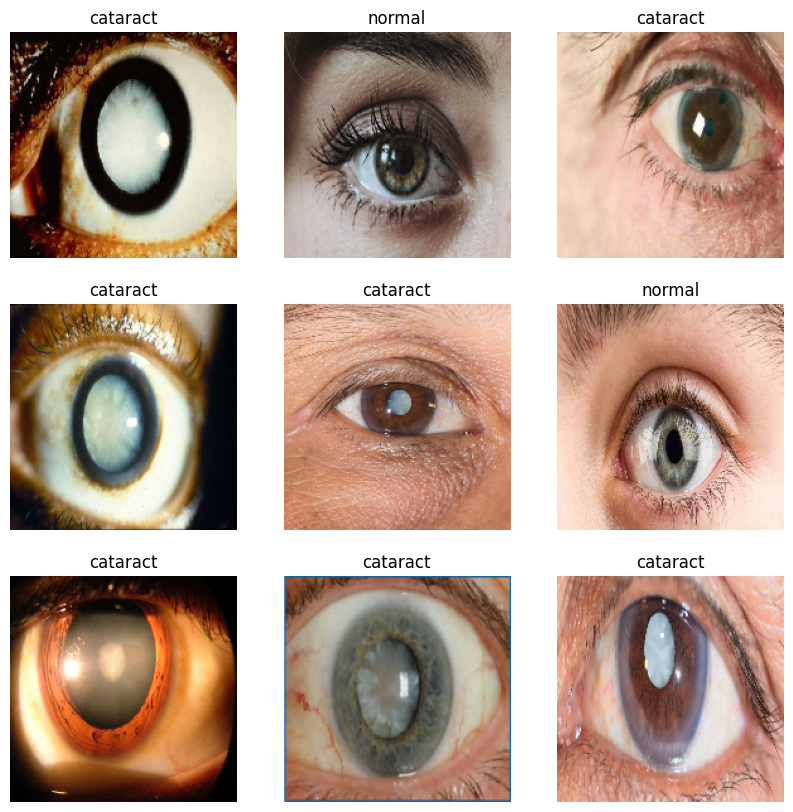

In [ ]:
import matplotlib.pyplot as plt

# Visualisasikan Data Sebelum dilatih

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
# Bandingkan Ukuran Gambar dengan Label

for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [ ]:
# Caching dataset untuk mempercepat proses pelatihan

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
from keras import layers
from keras.models import Sequential

# Tentukan Jumlah kelas

num_classes = len(class_names)

# Buat Model
model = Sequential([
    # Mencegah overfit dengan mempermainkan gambar
    layers.RandomFlip("vertical", input_shape=(img_height, img_width, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),

    # Rescale ukuran dari 0-255 ke 0-1
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

    # Convolutional Process
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),

    # Berguna untuk mencegah overfit dengan mematikan beberapa filter
    layers.Dropout(0.2),

    # Membuat kumpulan oixel menjadi satu dimensi
    layers.Flatten(),

    # Neural Network layers
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),

    # Memprediksi gambar ke sejumlah kelas mata katarak atau mata normal
    layers.Dense(num_classes)
])

In [ ]:
# Menyusun model dan mengukur kesalahan pengukuran

model.compile(optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_8 (RandomFlip)  (None, 180, 180, 3)       0         
                                                                 
 random_rotation_8 (RandomR  (None, 180, 180, 3)       0         
 otation)                                                        
                                                                 
 random_zoom_8 (RandomZoom)  (None, 180, 180, 3)       0         
                                                                 
 rescaling_8 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_24 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 90, 90, 32)        0         
 ng2D)                                                

In [ ]:
# Melatih Model dan menyimpan performance model ke dalam variable history

epochs=100
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=epochs
)

Epoch 1/100
16/16 [==============================] - 4s 76ms/step - loss: 0.7052 - accuracy: 0.5173 - val_loss: 0.6740 - val_accuracy: 0.7273
Epoch 2/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6586 - accuracy: 0.5927 - val_loss: 0.5294 - val_accuracy: 0.7603
Epoch 3/100
16/16 [==============================] - 1s 58ms/step - loss: 0.4753 - accuracy: 0.7882 - val_loss: 0.4149 - val_accuracy: 0.8182
Epoch 4/100
16/16 [==============================] - 1s 58ms/step - loss: 0.4233 - accuracy: 0.8106 - val_loss: 0.3545 - val_accuracy: 0.8926
Epoch 5/100
16/16 [==============================] - 1s 58ms/step - loss: 0.4016 - accuracy: 0.8473 - val_loss: 0.4199 - val_accuracy: 0.8595
Epoch 6/100
16/16 [==============================] - 1s 59ms/step - loss: 0.3356 - accuracy: 0.8595 - val_loss: 0.4128 - val_accuracy: 0.8678
Epoch 7/100
16/16 [==============================] - 1s 57ms/step - loss: 0.3172 - accuracy: 0.8676 - val_loss: 0.4369 - val_accuracy: 0.8760
Epoch 

In [ ]:
# Menampilkan akurasi dari hasil pelatihan
train_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

print(f"Akurasi Training: {train_accuracy[-1]*100:.2f}%")
print(f"Akurasi Testing: {validation_accuracy[-1]*100:.2f}%")

Akurasi Training: 98.98%
Akurasi Testing: 96.69%


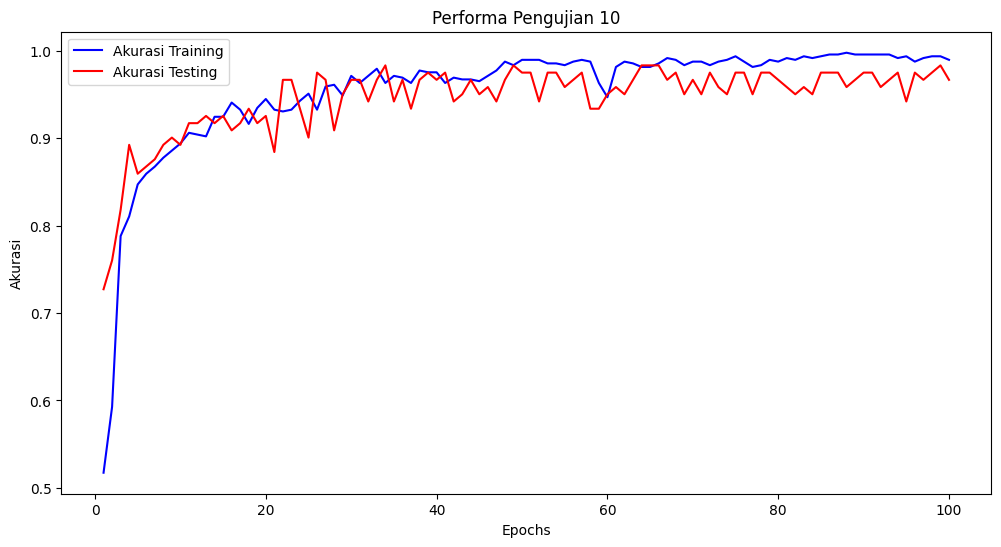

In [ ]:
# Visualisasi akurasi pelatihan dan validasi
epochs = range(1, epochs + 1)

plt.figure(figsize=(12, 6))
plt.plot(epochs, train_accuracy, 'b', label='Akurasi Training')
plt.plot(epochs, validation_accuracy, 'r', label='Akurasi Testing')
plt.title('Performa Pengujian 10')
plt.xlabel('Epochs')
plt.ylabel('Akurasi')
plt.legend()
plt.show()

**Test menggunakan data baru**

In [ ]:
# Upload data baru (data_baru.zip)

upload_files = files.upload()
print(upload_files)

Saving data_baru.zip to data_baru.zip
{'data_baru.zip': b'PK\x03\x04\x14\x00\x00\x00\x08\x00\x0b\x1f\x81U\xdd\x06\xb4A\x8cE\x00\x00DF\x00\x00\x10\x00\x00\x00data_baru/01.jpg\x9c\xbagTS_\xf4\xf7yC\x80\xd0\x9bA\x8a\xa1\xf7"R%\xf4\x80\xf4\x0e\x01A@\xa5I\x89\x884A\x82\xf4\x8e\x10:B\xa4C\x08\xa1\xa3tAA\xe9\xd2\x84P\x04\xe4G\t\x1dA\x9a\x08"\x8e\xffg\xcd3\xf3f^\xcc\xcc~u\xd6\xd9g\x9d\xb5?\xeb\xee\xbd\xcf\xfe\xaeu\xff\xce\xfd]\x06\x98\x0cu\rt\x01\x10\x08\x04\xfc/\xfb\xbb\x02H\xe9<\xf7t\x03\x00\x13\x13@\xfc\xdf\x06\x15@\x86\x00\x00\xf0\xbf\x15\x08\x10\x06\x00\x04\x08\x00\xfd\xaf\xf5\xffi\x7f\x17\x80;\x00\r\x04B\r\xa1\xa4\xa1\xa6\xa2\xa6\xa5\xa5\xa1c\xe4`bd``\xe4\xbe\xce\xc6\xc2!\xc8+,$\xc0+\xc0/zSIZT\xfc\xb6\x04\xbf\x80\xac\xb6\xecm\x155\x04\x02!,\xadk\xa4\xa3n\xa8\xa4\x81P\xfb\x9fK@\xb4\xb4\xb4\x8c\xf4\x8c\\LL\\jb\x02bj\xff\x9f\xedo7\xc0L\x05r\x01\xcd\x83A\xfc\x00\x193\x08\xcc\x0c\xfa\xdb\x0b\xf0\xfc\x8b\x95\x02\xf4\xbf\xec\x7f\x87\x0c"\x03\x93SPB\xa8\xa8ih\xff\x1dhf\x02\xc8@`0\x199\x98\x82\x8

In [ ]:
!unzip data_baru

Archive:  data_baru.zip
  inflating: data_baru/01.jpg        
  inflating: data_baru/010.jpg       
  inflating: data_baru/011.jpg       
  inflating: data_baru/02.jpg        
  inflating: data_baru/03.jpg        
  inflating: data_baru/04.jpg        
  inflating: data_baru/05.jpg        
  inflating: data_baru/07.jpg        
  inflating: data_baru/08.jpg        
  inflating: data_baru/09.jpg        
  inflating: data_baru/1.jpg         
  inflating: data_baru/10.jpg        
  inflating: data_baru/2.jpg         
  inflating: data_baru/3.jpg         
  inflating: data_baru/4.jpg         
  inflating: data_baru/5.jpg         
  inflating: data_baru/6.jpg         
  inflating: data_baru/7.jpg         
  inflating: data_baru/8.jpg         
  inflating: data_baru/9.jpg         


1/1 [==============================] - 0s 32ms/step


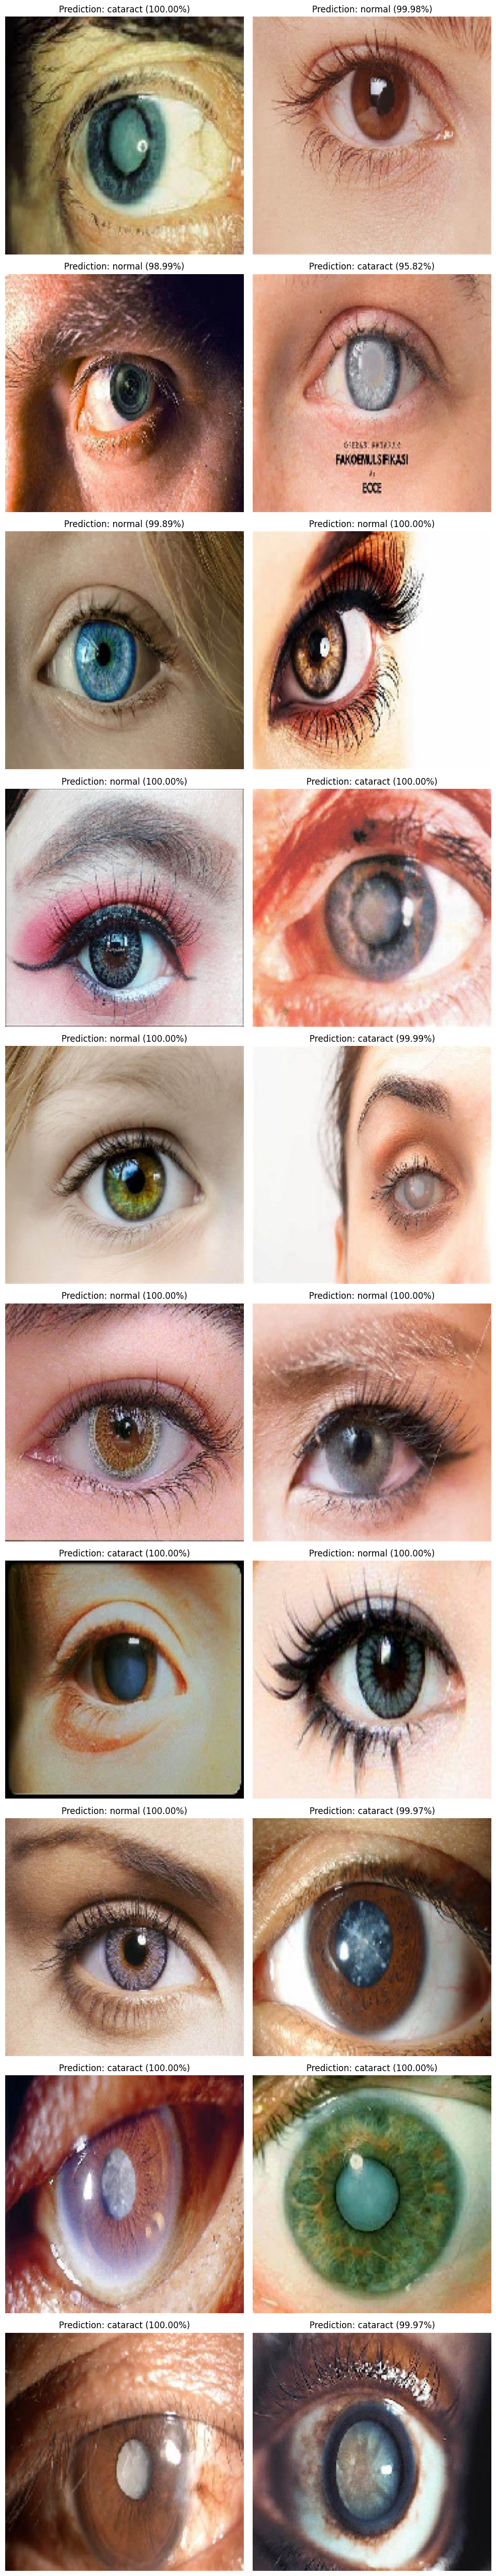

File: 2.jpg, Class: cataract, Confidence: 100.00%
File: 09.jpg, Class: normal, Confidence: 99.98%
File: 03.jpg, Class: normal, Confidence: 98.99%
File: 5.jpg, Class: cataract, Confidence: 95.82%
File: 07.jpg, Class: normal, Confidence: 99.89%
File: 011.jpg, Class: normal, Confidence: 100.00%
File: 05.jpg, Class: normal, Confidence: 100.00%
File: 3.jpg, Class: cataract, Confidence: 100.00%
File: 01.jpg, Class: normal, Confidence: 100.00%
File: 10.jpg, Class: cataract, Confidence: 99.99%
File: 02.jpg, Class: normal, Confidence: 100.00%
File: 010.jpg, Class: normal, Confidence: 100.00%
File: 9.jpg, Class: cataract, Confidence: 100.00%
File: 08.jpg, Class: normal, Confidence: 100.00%
File: 04.jpg, Class: normal, Confidence: 100.00%
File: 1.jpg, Class: cataract, Confidence: 99.97%
File: 6.jpg, Class: cataract, Confidence: 100.00%
File: 7.jpg, Class: cataract, Confidence: 100.00%
File: 4.jpg, Class: cataract, Confidence: 100.00%
File: 8.jpg, Class: cataract, Confidence: 99.97%


In [ ]:
import os
import tensorflow as tf
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Path ke folder yang berisi gambar yang ingin diprediksi
folder_path = "/content/data_baru"

# Dimensi gambar yang diharapkan oleh model
img_height, img_width = 180, 180

# List untuk menyimpan hasil prediksi untuk setiap gambar
predictions_list = []

# Mengatur subplot untuk menampilkan gambar secara berdampingan
num_images = len(os.listdir(folder_path))
num_rows = num_images // 2 + num_images % 2
fig, axes = plt.subplots(num_rows, 2, figsize=(10, 5 * num_rows))

# Loop melalui semua file di dalam folder
for i, filename in enumerate(os.listdir(folder_path)):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        # Path lengkap ke gambar
        img_path = os.path.join(folder_path, filename)

        # Load Image
        img = image.load_img(img_path, target_size=(img_height, img_width))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)

        # Predict model
        predictions = model.predict(img_array)
        score = tf.nn.softmax(predictions[0])

        # Prediction Result
        result = {
            "file": filename,
            "class": class_names[np.argmax(score)],
            "confidence": 100 * np.max(score)
        }

        # Menambahkan hasil prediksi ke dalam list
        predictions_list.append(result)

        # Menampilkan gambar dan hasil prediksi pada subplot
        ax = axes[i // 2, i % 2]
        ax.imshow(img)
        ax.set_title(f"Prediction: {result['class']} ({result['confidence']:.2f}%)")
        ax.axis('off')

# Menyusun tata letak subplot
plt.tight_layout()
plt.show()

# Menampilkan hasil prediksi untuk setiap gambar
for result in predictions_list:
    print("File: {}, Class: {}, Confidence: {:.2f}%".format(result["file"], result["class"], result["confidence"]))
